<a href="https://colab.research.google.com/github/ThoAus/learn-ligthning/blob/main/02_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! pip install lightning

In [2]:
import os
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import lightning as L

import torch.utils.data as data
from torchvision import datasets
import torchvision.transforms as transforms
import torchmetrics

import pandas as pd
import matplotlib.pyplot as plt

## Dataset an Dataloader
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [3]:
# Load data sets
transform = transforms.ToTensor()
train_set = datasets.MNIST(root="data", download=True, train=True, transform=transform)
test_set = datasets.MNIST(root="data", download=True, train=False, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5462392.48it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 225725.69it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2363294.75it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 746230.90it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [4]:
# Use 20% of training data for validation
train_set_size = int(len(train_set) * 0.8)
valid_set_size = len(train_set) - train_set_size

# Split the training data into a training and validation set
seed = torch.Generator().manual_seed(42)
train_set, valid_set = data.random_split(train_set, [train_set_size, valid_set_size], generator=seed)

In [5]:
# Define hyperparameters
input_size = 28 * 28
num_classes = 10
batch_size = 64

In [6]:
# Create the dataloader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

#### Show batch

In [7]:
# Define function to show a batch of images
def show_batch(X, y):
    fig, axs = plt.subplots(1, 10, figsize=(10, 2))
    for i in range(10):
        axs[i].imshow(X[i].squeeze(), cmap="gray")
        axs[i].axis("off")

    for i, ax in enumerate(axs):
        ax.set_title(y[i].item())

    plt.show()

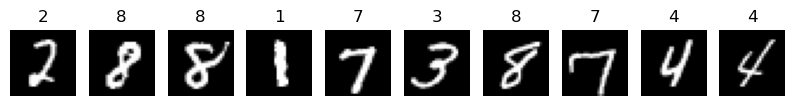

In [8]:
# Take a batch of data
X, y = next(iter(train_loader))

# Show a batch of images
show_batch(X, y)

## Modules and Model
https://lightning.ai/docs/pytorch/stable/common/lightning_module.html

In [9]:
# Define a simple neural network as a PyTorch Lightning module
# Source: GitHub aladdinpersson/Machine-Learning-Collection

class simple_NN(L.LightningModule):
    # Define the network architecture
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    # Define the forward pass
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    # Define the training step
    def training_step(self, batch, batch_idx):
        loss, accuracy, scores, y = self._common_step(batch, batch_idx)
        self.log_dict({'train_loss': loss, 'train_acc': accuracy},
                      on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    # Define the validation step
    def validation_step(self, batch, batch_idx):
        loss, accuracy, scores, y = self._common_step(batch, batch_idx)
        self.log_dict({'val_loss': loss, 'val_acc': accuracy},
                      on_step=False, on_epoch=True, prog_bar=True)
        return loss

    # Define the test step
    def test_step(self, batch, batch_idx):
        loss, accuracy, scores, y = self._common_step(batch, batch_idx)
        self.log_dict({'test_loss': loss, 'test_acc': accuracy},
                      on_step=False, on_epoch=True)
        return loss

    # Helper function to reduce code duplication
    def _common_step(self, batch, batch_idx):
        x, y = batch 
        x = x.reshape(x.size(0), -1)
        scores = self.forward(x)
        loss = self.loss_fn(scores, y)
        accuracy = self.accuracy(scores, y) 
        return loss, accuracy, scores, y

    # Define the predict step
    def predict_step(self, batch, batch_idx):
        x, y = batch 
        x = x.reshape(x.size(0), -1)
        scores = self.forward(x)
        preds = torch.argmax(scores, dim=1)
        return preds

    # Define the configure_optimizers method
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

## Trainer
https://lightning.ai/docs/pytorch/stable/common/trainer.html

In [10]:
# Initialize network (resets the network)
model = simple_NN(input_size=input_size, num_classes=num_classes)

In [11]:
# Initialize trainer and fit model
trainer = L.Trainer(max_epochs=25)

trainer.fit(model, train_loader, valid_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\thoma\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: c:\Users\thoma\Documents\GitHub\learn-ligthning\lightning_logs

  | Name     | Type               | Params
------------------------------------------------
0 | fc1      | Linear             | 39.2 K
1 | fc2      | Linear             | 510   
2 | loss_fn  | CrossEntropyLoss   | 0     
3 | accuracy | Mul

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\thoma\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\thoma\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


#### Load and visualize the log-file

In [13]:
# Load the log-file and plot the training and validation loss
version = 0
log_file = f"lightning_logs/version_{version}/metrics.csv"
df = pd.read_csv(log_file)

# Take the mean value for each epoch
df = df.groupby("epoch").mean().reset_index()

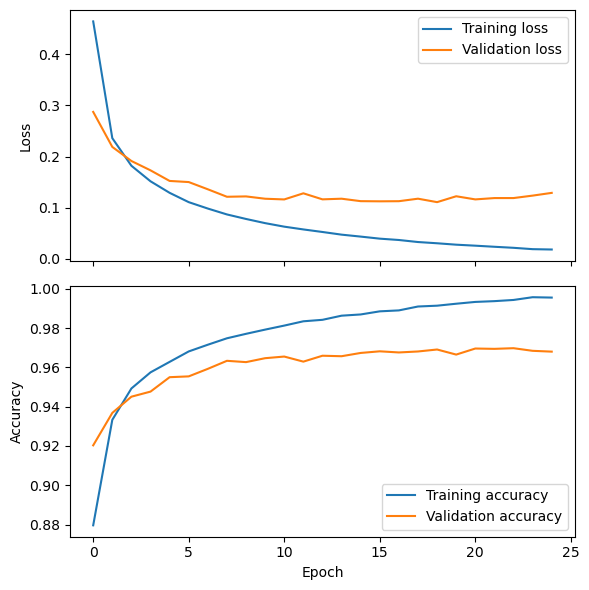

In [ ]:
# Plot the training and validation loss
fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True, tight_layout=True)
ax[0].plot(df["epoch"], df["train_loss"], label="Training loss")
ax[0].plot(df["epoch"], df["val_loss"], label="Validation loss")
ax[0].set_ylabel("Loss")
ax[0].legend()

# Plot the training and validation accuracy
ax[1].plot(df["epoch"], df["train_acc"], label="Training accuracy")
ax[1].plot(df["epoch"], df["val_acc"], label="Validation accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.show()

#### Test the model on test-dataset

In [14]:
# Test the model
trainer = L.Trainer()
trainer.test(model, dataloaders=DataLoader(test_set, batch_size=batch_size))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\thoma\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.968999981880188     │
│         test_loss         │    0.1204320415854454     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.1204320415854454, 'test_acc': 0.968999981880188}]